# <center>BioSCape Data Skills Workshop: From the Field to the Image</center>
<center><img src="images/121229-87.png"/></center>

[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This workshop will equip participants with the skills to find, subset, and visualize the various BioSCape field and airborne (imaging spectroscopy and full-waveform lidar) data sets. Participants will learn data skills through worked examples in terrestrial and aquatic ecosystems, including: wrangling lidar data, performing band math calculations, calculating spectral diversity metrics, spectral unmixing, machine learning and image classification, and mapping functional traits using partial least squares regression. The workshop format is a mix of expert talks and interactive coding notebooks and will be run through the BioSCape Cloud computing environment.

**Date:** October 9 - 11, 2024 Cape Town, South Africa</center>

**Host:** NASA’s Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), in close collaboration with BioSCape, the South African Environmental Observation Network (SAEON), the University of Wisconsin Madison (Phil Townsend), The Nature Conservancy (Glenn Moncrieff), the University of California Merced (Erin Hestir), the University of Cape Town (Jasper Slingsby), Jet Propulsion Laboratory (Kerry Cawse-Nicholson), and UNESCO.

**Instructors:** 
- In-person contributors: Anabelle Cardoso, Erin Hestir, Phil Townsend, Henry Frye, Glenn Moncrieff, Jasper Slingsby, Michele Thornton, Rupesh Shrestha
- Virtual contributors: Kerry Cawse-Nicholson, Nico Stork, Kyle Kovach

**Audience:** This training is primarily intended for government natural resource management agency representatives and field technicians in South Africa, as well as local academics and students, especially those connected to the BioSCape Team. 


## Calculate Turbidity over a PRISM scene
-----

### Overview
-----
Turbidity is a key water quality parameter that measures the clarity or cloudiness of water, primarily caused by the presence of suspended particles. These particles can include silt, clay, organic matter, algae, plankton, and other microscopic organisms. Essentially, turbidity indicates how much material is present in the water that scatters or absorbs light, which directly impacts its transparency.

![](images/turbidity.png)
Water samples showing increasing turbidity and changes in water color. From https://blogs.worldbank.org/en/water/how-test-water-quality-here-are-some-low-cost-low-tech-options 

As a water quality indicator, turbidity can reveal much about aquatic habitats. High turbidity can reduce light penetration, which affects photosynthesis in aquatic plants and algae. This reduction in primary productivity impacts the entire aquatic food web. High turbidity can also clog fish gills and reduce habitat quality for aquatic organisms. High turbidity often correlates with elevated nutrient levels, particularly phosphorus, which can promote excessive algal growth, leading to eutrophication. This process can deplete oxygen levels in the water, harming fish and other aquatic organisms. In some instances, moderate to high turbidity is necessary for certain fish species, as they are well-adapted for low light environments. 

Additionally, turbidity is a critical parameter for drinking water quality. Elevated turbidity may indicate the presence of pathogens such as bacteria, viruses, and parasites, as these microorganisms can attach to suspended particles. Thus, clear water is generally considered safer for consumption.

The Portable Remote Imaging Spectrometer (PRISM) is especially designed for aquatic applications, and is well suited to measure water-leaving reflectance, which can be used to calculate turbidity. In this notebook, we will revisit opening a PRISM scene over the Theerwaterskloof Dam, the largest Dam in the province, accounting for 54% of the province's water supply. The region experienced heavy rainfall during the winter and spring of 2023, leading to high river flows and filling the dam to 100% with overspilling by the end of September 2023.  

### Learning Objectives
1. Mount the BioSCape SMCE S3 object storage in a local environment
2. Examine PRISM data using GDAL
3. Identify band numbers and associated wavelengths
4. Calculate turbidity using a single-band semi-empirical algorithm 
5. Create and save a turbidity map as a GeoTIFF file
6. Visualize turbidity maps in QGIS
7. Compare two turbidity maps derived from two different wavelengths 

### Requirements

In [1]:
import s3fs
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import pandas as pd
from os import path
import rioxarray
gdal.UseExceptions()

### Content
----

Explore the BioSCape SMCE S3 PRISM data holdings
Let's start by exploring the BioSCape Airborne currently data available on the cloud in Amazon Storage. This AWS S3 storage is specific to the SMCE that provides data access and analytics environment to the BioSCape Science Team as well as interested researchers.
We'll learn how to mount the S3 object storage on our local environment, as well as learning how to bring other data to the analysis.

SMCE = Science Managed Cloud Environment
S3 = Amazon Simple Storage Service (S3) is a cloud storage service that allows users to store and retrieve data
S3Fs is a Pythonic open source tool that mounts S3 object storage locally. S3Fs provides a filesystem-like interface for accessing objects on S3.
The top-level class S3FileSystem holds connection information and allows typical file-system style operations like ls
ls is a UNIX command to list computer files and directories

In [2]:
# Use S3Fs to list the BioSCape data on the BioSCape SMCE S3 storage
s3 = s3fs.S3FileSystem(anon=False)
files = s3.ls('bioscape-data/')
files

['bioscape-data/AVNG',
 'bioscape-data/BioSCapeVegPolys2023_10_18',
 'bioscape-data/BioSCapeVegPolys2023_10_18.geoparquet',
 'bioscape-data/LVIS',
 'bioscape-data/PRISM',
 'bioscape-data/bioscape_avng.yaml']

#### Portable Remote Imaging Spectrometer (PRISM)

In [3]:
PRISM_flightlines = s3.ls('bioscape-data/PRISM')
PRISM_flightlines

['bioscape-data/PRISM/L2']

Examine PRISM Reflectance Data as a GDAL Raster Dataset
GDAL (Geospatial Data Abstraction Library) is a translator library for raster and vector geospatial data formats
In this step, we will use GDAL to examine the PRISM reflectance data that is in ENVI binary format (a proprietary, but common distribution format)

We need to configure our S3 credentials for GDAL
The GDAL utility expects S3 links to be formated with the GDAL virtual file system (VSI) S3 path. We therefore have to use the VSI path to access the files with GDAL. We'll substitute the S3 link with the VSI (vsis3) link(s).

In [4]:
rfl_link = 'bioscape-data/PRISM/L2/prm20231126t080430_rfl_ort'

In [5]:
image_open = gdal.Open(path.join('/vsis3', rfl_link))
#image_open.GetMetadata()

In [6]:
# lists of band numbers and band center
band_numbers = [int(b.split("_")[1]) for b in image_open.GetMetadata().keys() if b != "wavelength_units"]
band_wavelength = [float(b.split(" ")[0]) for b in image_open.GetMetadata().values() if b != "Nanometers"]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band wavelength (nm)": band_wavelength}, index = band_wavelength).sort_index()

print(bands.to_string())

             Band number  Band wavelength (nm)
350.554829             1            350.554829
353.385086             2            353.385086
356.215399             3            356.215399
359.045768             4            359.045768
361.876193             5            361.876193
364.706675             6            364.706675
367.537213             7            367.537213
370.367807             8            370.367807
373.198457             9            373.198457
376.029164            10            376.029164
378.859927            11            378.859927
381.690746            12            381.690746
384.521621            13            384.521621
387.352553            14            387.352553
390.183541            15            390.183541
393.014585            16            393.014585
395.845685            17            395.845685
398.676841            18            398.676841
401.508054            19            401.508054
404.339323            20            404.339323
407.170649   

Take note of the band numbers and corresponding wavelengths. We will use this information later on.

In [7]:
# Open the PRISM ENVI file and read the file bands, row, cols
#image_open = gdal.Open(gdal_url)

nbands = image_open.RasterCount
nrows = image_open.RasterYSize
ncols = image_open.RasterXSize

print("\n".join(["Bands:\t"+str(nbands), "Rows:\t"+str(nrows), "Cols:\t"+str(ncols)]))

Bands:	246
Rows:	2789
Cols:	655


### Calculate Turbidity
We are going to use a simple, but globally validated single-band algorithm for turbidity developed by [Nechad et al. (2010)](https://www.sciencedirect.com/science/article/abs/pii/S0034425709003617). It is a semi-empirical water-leaving reflectance based algorithm. It has been found to be particularly useful for coastal, estuarine, and inland waters. It uses the relationship between water-leaving reflectance and turbidity, relying on measurements from visible and near-infrared (NIR) spectral bands to quantify the concentration of suspended particulate matter (SPM).

$$T=\frac{A*R_{w}}{1-\frac{R_{w}}{C}}$$

Where $R_{w}$ is the water-leaving reflectance at a given wavelength, and A and C are given below. 

The algorithm typically uses red or NIR bands (e.g., around 645 nm or 858 nm). The choice of wavelength depends on the water type; for example, red bands are generally used in relatively clear waters, while NIR bands are more suitable for highly turbid waters. As you have observed, as turbidity, or SPM, increases, water-leaving reflectance tends to increase, and peak reflectance tends to shift to longer wavelengths.

The coefficients $A$ and $C$ are empirically derived through in-situ measurements of turbidity and corresponding remote sensing data, which helps in tuning the model for different environments.  In this example, we will use parameters taken from [Dogliotti et al. 2011](https://www.sciencedirect.com/science/article/pii/S0034425714003654).

We are going to implement the algorithm on two wavelengths, and we will compare the results. 

| Wavelength | PRISM band | A     | C      |
| ---------- | ---------- | ----  | ------ |
| 645 nm     | 105        | 228.1 | 0.1641 |
| 858 nm     | 180        | 3078.9| 0.2112 |


#### Using GDAL to read a raster file as a numerical array
convert an existing Gdal Dataset or a Band into a numpy array with the ReadAsArray() function

In [14]:
img_red = image_open.GetRasterBand(105).ReadAsArray()  # Band 105 is 645nm 
img_nir = image_open.GetRasterBand(180).ReadAsArray()  # Band 181 is 858nm

In [15]:
# Calculate Turbidity

# Define the function T
def T(A, C, Rw):
    return (A * Rw) / (1 - (Rw / C))

turb_red = T(228.1, 0.1641, img_red)
turb_nir = T(3078.9, 0.2112, img_nir)

#### Explore the Results

In [17]:
# Compare turbidity values of two different aquatic plots
# Note here when we print an element in a numpy array, the order is row column 

pixel1 = turb_red[770, 300] #  pixel location: row, col
pixel2 = turb_red[770, 75] # pixel location: row, col

print("The turbidity (645 nm) value at pixel 1 is " + str(pixel1))
print("The turbidity (645 nm) value at pixel 2 is " + str(pixel2))

The turbidity (645 nm) value at pixel 1 is 40.846443
The turbidity (645 nm) value at pixel 2 is 25.71505


In [18]:
pixel3 = turb_nir[770, 300] #  pixel location: row, col
pixel4 = turb_nir[770, 75] # pixel location: row, col

print("The turbidity (858 nm) value at pixel 3 is " + str(pixel3))
print("The turbidity (858 nm) value at pixel 4 is " + str(pixel4))

The turbidity (858 nm) value at pixel 3 is 59.01046
The turbidity (858 nm) value at pixel 4 is 41.42754


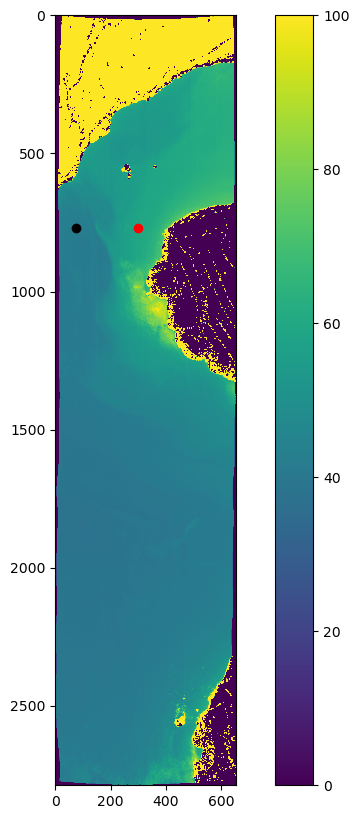

In [22]:
plt.scatter(300,770, color='red')
plt.scatter(75,770, color='black')
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['figure.dpi'] = 100
#plt.imshow(turb_red, vmin=0, vmax=100) # not run
plt.imshow(turb_nir, vmin=0, vmax=100)
plt.colorbar()
plt.show()

### Export turbidity maps as a stacked projected geoTIFFs

In [23]:
img_red = image_open.GetRasterBand(105).ReadAsArray()  # Band 105 is 645nm red
img_nir = image_open.GetRasterBand(181).ReadAsArray()  # Band 70 is 860nm nir

outfile = ('prism_turbidity.tif')
rows = image_open.RasterYSize
cols = image_open.RasterXSize
datatype = image_open.GetRasterBand(1).DataType
projection = image_open.GetProjection()
transform = image_open.GetGeoTransform()

driver = gdal.GetDriverByName("GTiff")
DataSetOut = driver.Create(outfile, cols, rows, 2, datatype) # 2 band stack
DataSetOut.GetRasterBand(1).WriteArray(turb_red) # note the order of the band stack
DataSetOut.GetRasterBand(2).WriteArray(turb_nir)
DataSetOut.SetProjection(projection)
DataSetOut.SetGeoTransform(transform)
DataSetOut = None

#### Open QGIS in the Hub Desktop,
- From a Launcher tab, start the Desktop
- At the bottom of the Desktop screen, use the Application Finder to find and launch QGIS
- Using the Home file system, maneuver to the correct file folder containing the prism_turbidity.tif file,
and view the prism_turbidity.tif image you just created !

![QGIS](images/Desktop_applicationfinder_QGIS.PNG)

Note that we have created a two-band image. We can visualize each band to compare the two retrievals. 
- Load band 1 (turbidity from the red band)
- Duplicate the layer and load band 2 (turbidity from the nir band)

HINT: under Symbology, set the Min/Max Value Settings to 0-100 so we are comparing the same scale

HINT: under Transparency, set the NoData value to 0

![](images/qgis_turb_red.png)
![](images/qgis_turb_nir.png)

- a copy of the output prism_turbidity.tif file is in the workshop folder `//shared/users/bioscape_ZA24workshop_data/RS_data/PRISM_Notebook`